# Guerlédan seabot data analysis

**Analysis to do:**

- compute averaged spectra
- add transfer function estimates and leverage for interpretation spectral analysis (relative displacement vs isopycnal displacement ratio)
- reconstruct dynamics (use float library), estimate $V_{air}$
- **à vérifier** `test_guerledan_2024_02_09/night/seabot5/rosbag2_2024_02_08-21_00_48/data/observer/temperature.npz` is empty
- animate float behavior for illustration purposes
- compare measured depth with that interpolated from the bathymetric map and an estimate of the position - road to horizontal position assessment
- Question: par quoi la variabilité de température est-elle contrôlée? Hypothèse: turbulence, capteur, bruit haute fréquence

**To improve in future deployments:**

- collect independent GPS fixes at deployments/recoveries
- avoid corrupted GPS data streams
- make sure at least one vertical profile mission is performed to know stratification (not done in 2023/10)
- vertical profile missions are sometime not continuously ascending and descending which complicates having consistent clean vertical profile of hydrology
- did not find distance to seafloor from echosounder ... could be useful to constraint trajectories: TLM règle export des données (`driver/profile`)

**To add to floats:**

- increase autonomy
- com radio/iridium
- add a compass in the float (Lien et al. 1998)
- add sail

**Deployments ideas:**

- collocated iso-T + iso-depth + scan
- collocated no sail + sail deployment


In [1]:
import os
from glob import glob

import xarray as xr
import pandas as pd
import numpy as np

#%matplotlib inline
import matplotlib.pyplot as plt
plt.rc('figure', titlesize=10)
plt.rc('axes', titlesize=10)
import hvplot.pandas # noqa
from cmocean import cm

import pynsitu as pin
import cognac.ufloat as fl
import seabot as sb
crs = sb.crs

show_hv=True
show_hv=False

## load data

In [2]:
#root_path = "/Users/aponte/Current_Projects/ensta/guerledan_202310/data_seabot"
root_dir = "/Users/aponte/Current_Projects/ensta/guerledan/"

#seabot_dir = os.path.join(root_dir, "202310/data_seabot")
#cp_yml = "guerledan_202310.yaml"

seabot_dir = os.path.join(root_dir, "202402/data_seabot")
cp_yml = "guerledan_202402.yaml"

# load seabot
D = sb.walk_load_repo(seabot_dir)
# load yaml file
cp = pin.Campaign(cp_yml)
#cp = pin.Campaign("guerledan_202402.yaml")
M, iM = sb.match_dict_cp(D, cp)

/Users/aponte/Current_Projects/ensta/guerledan/202402/data_seabot/test_guerledan_2024_02_05/seabot4/rosbag2_2024_02_05-20_06_37
/Users/aponte/Current_Projects/ensta/guerledan/202402/data_seabot/test_guerledan_2024_02_05/seabot5/rosbag2_2024_02_05-20_06_54
/Users/aponte/Current_Projects/ensta/guerledan/202402/data_seabot/test_guerledan_2024_02_06/test_15m/seabot1/rosbag2_2024_02_06-15_11_30
/Users/aponte/Current_Projects/ensta/guerledan/202402/data_seabot/test_guerledan_2024_02_06/test_15m/seabot3/rosbag2_2024_02_06-15_08_44
multiple rosbags encountered in /Users/aponte/Current_Projects/ensta/guerledan/202402/data_seabot/test_guerledan_2024_02_06/test_emission_inter_flotteur/seabot1
/Users/aponte/Current_Projects/ensta/guerledan/202402/data_seabot/test_guerledan_2024_02_06/test_emission_inter_flotteur/seabot1/rosbag2_2024_02_06-16_25_01
/Users/aponte/Current_Projects/ensta/guerledan/202402/data_seabot/test_guerledan_2024_02_06/test_emission_inter_flotteur/seabot1/rosbag2_2024_02_06-16_5

In [3]:
# extract relevant data sets
Dk = sb.dfilter(D, "observer_kalman")
Dd = sb.dfilter(D, "observer_depth")
#Dpiston = sb.dfilter(D, "driver_piston")

#colors = {d: c for d, c in zip(list(Dk), pin.get_cmap_colors(len(Dk)))}
colors = {d: cp[iM[d][0]]["color"] if d in iM else "k" for d in list(Dk)}

# combine temperature and kalman data
Dc = sb.combine(
    D, "1s", 
    ka="observer_kalman", 
    te="observer_temperature", 
    pi="driver_piston",
    de="observer_depth",
)
# add/massage variables
for d, df in Dc.items():
    # append depth filtered to match temperature
    #sb.append_depth_filtered(df, 2., key="ka_depth")
    sb.append_depth_filtered(df, 2., key="de_depth")
    # append piston displacement and volume
    df["pi_course"], df["pi_volume"] = sb.position2course(df["pi_position"])

# inspect if need be:
#df["depth"].hvplot() * df["depth_filtered"].hvplot()    

In [4]:
df = D[('test_guerledan_2024_02_05', 'seabot4', 'safety_safety')]
#df["depth_limit"]  #.plot()
df["limit_depth"].hvplot()

:Curve   [time]   (limit_depth)

#### get info to fill yaml file

In [5]:
Dk = sb.dfilter(D, "observer_kalman")
sb.pprint(Dk)

test_guerledan_2024_02_05 / seabot4 2024/02/05 20:06:44 to 2024/02/05 20:50:17
test_guerledan_2024_02_05 / seabot5 2024/02/05 20:06:56 to 2024/02/05 20:50:09
test_guerledan_2024_02_06 / test_15m / seabot1 2024/02/06 15:11:40 to 2024/02/06 15:37:41
test_guerledan_2024_02_06 / test_15m / seabot3 2024/02/06 15:08:47 to 2024/02/06 15:37:44
test_guerledan_2024_02_06 / test_emission_inter_flotteur / seabot1 / rosbag2_2024_02_06-16_25_01 2024/02/06 16:25:01 to 2024/02/06 16:45:17
test_guerledan_2024_02_06 / test_emission_inter_flotteur / seabot1 / rosbag2_2024_02_06-16_57_08 2024/02/06 16:57:08 to 2024/02/06 17:33:15
test_guerledan_2024_02_06 / test_emission_inter_flotteur / seabot3 2024/02/06 16:25:35 to 2024/02/06 17:26:17
test_guerledan_2024_02_07 / night / seabot4 2024/02/06 17:20:16 to 2024/02/07 08:45:10
test_guerledan_2024_02_07 / night / seabot5 2024/02/06 17:20:31 to 2024/02/07 08:45:35
test_guerledan_2024_02_08 / night / seabot4 2024/02/07 15:37:15 to 2024/02/08 08:53:00
test_guerle

(<Figure size 1800x200 with 1 Axes>,
 <Axes: title={'center': 'test_guerledan_2024_02_09/night/seabot5'}>)

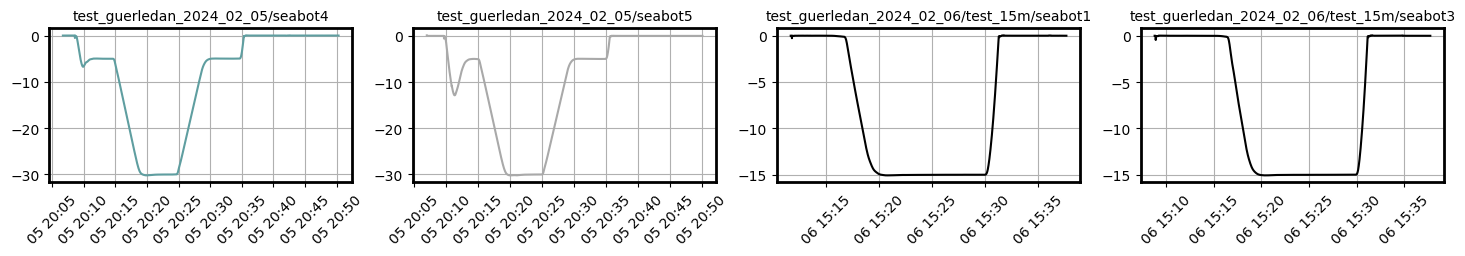

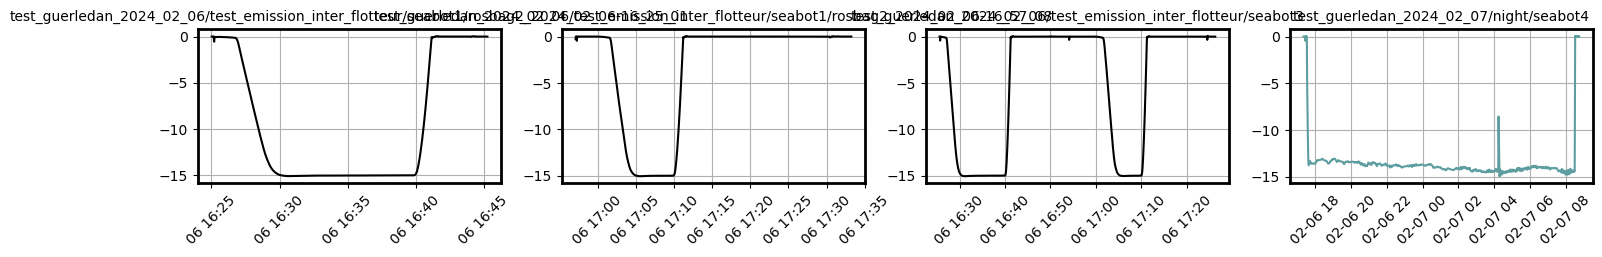

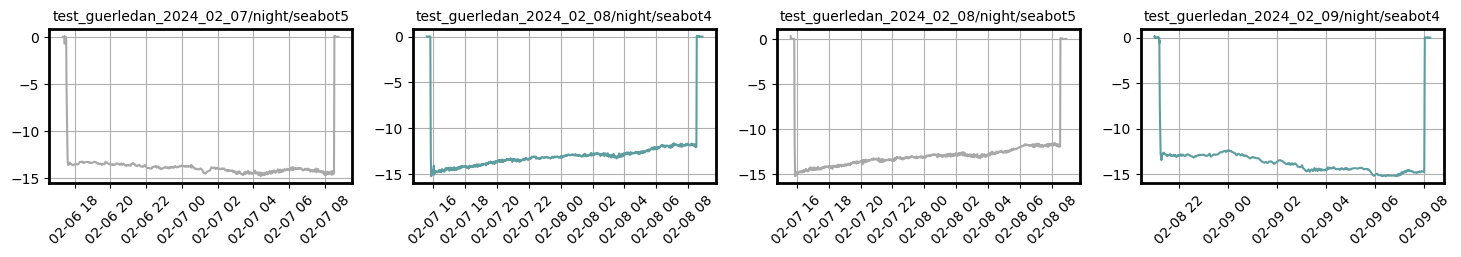

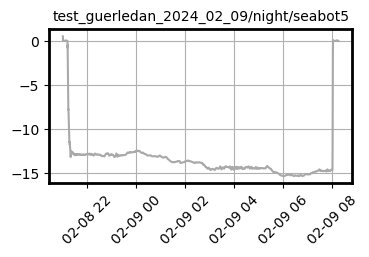

In [6]:
# thumbnail of all depth profiles
sb.plot_depth(Dc, dkey="ka_depth", legend=True, thumbnail=True, colors=colors)

(<Figure size 1500x400 with 1 Axes>, <Axes: >)

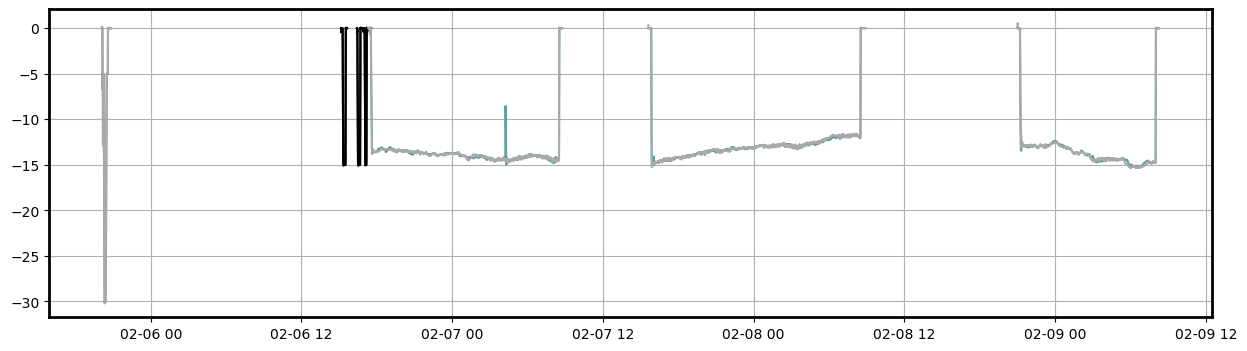

In [7]:
#sb.plot_depth(Dc, legend=True)
sb.plot_depth(Dc, legend=False, colors=colors)

<Axes: title={'center': 'guerledan_202402'}>

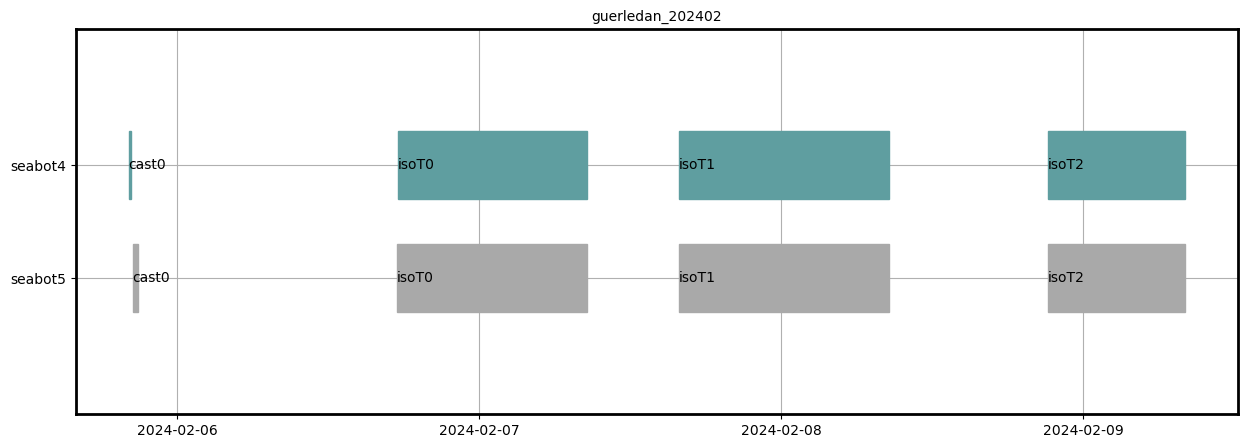

In [8]:
cp.timeline(labels=True)

#### show sampling rates

In [9]:
#sb.pprint(D)

In [10]:
def show_sampling_rate(D):
    keys = ["_".join(d) for d in list(D)]
    data = []
    for d, df in D.items():
        dt = df["time_since_start"].diff()/pd.Timedelta("1s")
        data.append(np.mean(dt))
    return pd.Series(data, index=keys)

for label in ["observer_kalman", "observer_temperature"]:
    _D = sb.dfilter(D, label)
    s = show_sampling_rate(_D)
    print(f"-- {label}, dt (s):")
    print(s)

-- observer_kalman, dt (s):
test_guerledan_2024_02_05_seabot4                                                             0.200005
test_guerledan_2024_02_05_seabot5                                                             0.199855
test_guerledan_2024_02_06_test_15m_seabot1                                                    0.200002
test_guerledan_2024_02_06_test_15m_seabot3                                                    0.199999
test_guerledan_2024_02_06_test_emission_inter_flotteur_seabot1_rosbag2_2024_02_06-16_25_01    0.199997
test_guerledan_2024_02_06_test_emission_inter_flotteur_seabot1_rosbag2_2024_02_06-16_57_08    0.200015
test_guerledan_2024_02_06_test_emission_inter_flotteur_seabot3                                0.200009
test_guerledan_2024_02_07_night_seabot4                                                       0.200003
test_guerledan_2024_02_07_night_seabot5                                                       0.200001
test_guerledan_2024_02_08_night_seabot4      

#### show positions

In [11]:
#Dpos = dfilter(Df, 'driver_fix')
Dpos = sb.dfilter(D, 'driver_fix')
sb.pprint(Dpos)

test_guerledan_2024_02_05 / seabot4 2024/02/05 20:06:44 to 2024/02/05 20:50:17
test_guerledan_2024_02_05 / seabot5 2024/02/05 20:06:57 to 2024/02/05 20:50:09
test_guerledan_2024_02_06 / test_15m / seabot1 2024/02/06 15:11:40 to 2024/02/06 15:37:41
test_guerledan_2024_02_06 / test_15m / seabot3 2024/02/06 15:08:44 to 2024/02/06 15:37:44
test_guerledan_2024_02_06 / test_emission_inter_flotteur / seabot1 / rosbag2_2024_02_06-16_25_01 2024/02/06 16:25:01 to 2024/02/06 16:45:17
test_guerledan_2024_02_06 / test_emission_inter_flotteur / seabot1 / rosbag2_2024_02_06-16_57_08 2024/02/06 16:57:09 to 2024/02/06 17:33:15
test_guerledan_2024_02_06 / test_emission_inter_flotteur / seabot3 2024/02/06 16:25:35 to 2024/02/06 17:26:17
test_guerledan_2024_02_07 / night / seabot4 2024/02/06 17:20:19 to 2024/02/07 08:45:09
test_guerledan_2024_02_07 / night / seabot5 2024/02/06 17:20:34 to 2024/02/07 08:45:35
test_guerledan_2024_02_08 / night / seabot4 2024/02/07 15:37:15 to 2024/02/08 08:53:01
test_guerle

Some of the GPS data is crazy:

- 2024_02_07 and seabot 5

In [12]:
# manually search for good gps times

#sb.show_gps(Dpos, Dk, 0, True)
#sb.show_gps(Dpos, Dk, 0, False)

#i = 7
#print(list(Dpos)[i])
#sb.show_gps(Dpos, Dk, i, None, full=True)

In [13]:
# extract positions from dataframes

deployments = {}
for p, k in M.items():
    print(p, k)
    m = cp[p[0]][p[1]].meta
    if "gps_start" in m:
        deployments[k] = dict(start=pd.Timestamp(m["gps_start"]), end=pd.Timestamp(m["gps_end"]))    
        
sb.load_gps(deployments, Dpos) # inplace

('seabot4', 'cast0') ('test_guerledan_2024_02_05', 'seabot4')
('seabot4', 'isoT0') ('test_guerledan_2024_02_07', 'night', 'seabot4')
('seabot4', 'isoT1') ('test_guerledan_2024_02_08', 'night', 'seabot4')
('seabot4', 'isoT2') ('test_guerledan_2024_02_09', 'night', 'seabot4')
('seabot5', 'cast0') ('test_guerledan_2024_02_05', 'seabot5')
('seabot5', 'isoT0') ('test_guerledan_2024_02_07', 'night', 'seabot5')
('seabot5', 'isoT1') ('test_guerledan_2024_02_08', 'night', 'seabot5')
('seabot5', 'isoT2') ('test_guerledan_2024_02_09', 'night', 'seabot5')


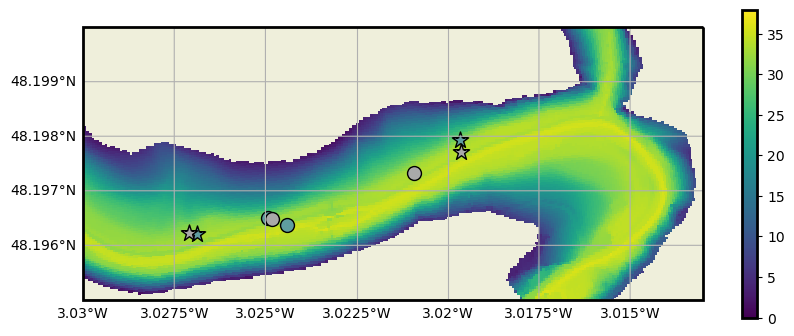

In [14]:
mapkw = dict(
    figsize=(10,4),
    #extent=[-3.03, -3.018, 48.195, 48.2],
    extent=cp["bounds"],
    tile=False,
    #tile_level=16,
    bathy=cp["bathy"]["path"], 
)
fig, ax = sb.plot_map(**mapkw)

for d, info in deployments.items():
    c = colors[d]
    ax.scatter(info["start_lon"], info["start_lat"], s=100, c=c, marker="o", edgecolor="k", transform=crs)
    ax.scatter(info["end_lon"], info["end_lat"], s=150, c=c, marker="*", edgecolor="k", transform=crs) #, edgecolor="k")
    #ax.text(info["start_lon"], info["start_lat"], "/".join(iM[d]), size=8, transform=crs)
    #ax.text(info["end_lon"], info["end_lat"], "/".join(iM[d]), size=8, transform=crs)

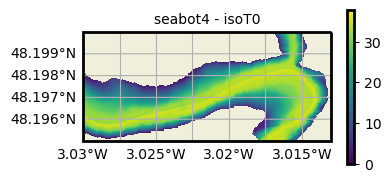

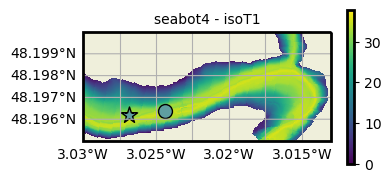

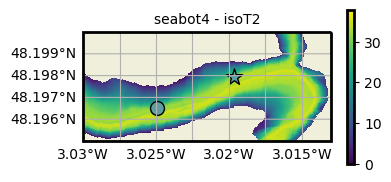

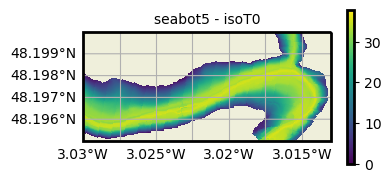

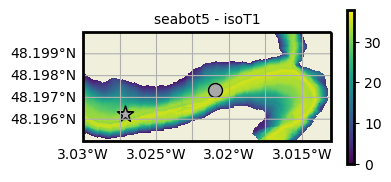

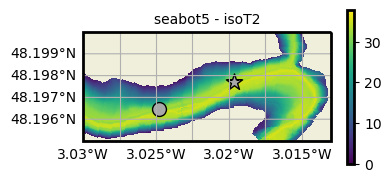

In [15]:
mapkw["figsize"] = (4,2)
for d, info in deployments.items():
    fig, ax = sb.plot_map(**mapkw)
    c = colors[d]
    ax.scatter(info["start_lon"], info["start_lat"], s=100, c=c, marker="o", edgecolor="k", transform=crs)
    ax.scatter(info["end_lon"], info["end_lat"], s=150, c=c, marker="*", edgecolor="k", transform=crs) #, edgecolor="k")
    ax.set_title(" - ".join(iM[d]))

**WARNING**

('test_guerledan_2024_02_08', 'seabot5') never aquired a good GPS fix at start up

Make sure GPS position is collected next times

We override with ('test_guerledan_2024_02_08', 'seabot4') start position plus a small (3m) offset

In [16]:
if cp["name"]=="guerledan_202402":
    for k in ["start_lon", "start_lat"]:
        deployments[('test_guerledan_2024_02_08', 'night', 'seabot5')][k] = \
            deployments[('test_guerledan_2024_02_08', 'night', 'seabot4')][k] + 3e-5

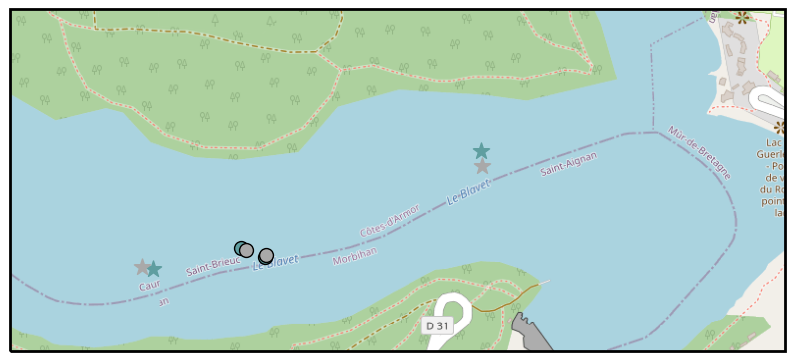

In [17]:
mapkw = dict(
    figsize=(10,5),
    #extent=[-3.03, -3.018, 48.195, 48.2],
    extent=cp["bounds"],
    tile_level=16,
)
fig, ax = sb.plot_map(**mapkw)

for d, info in deployments.items():
    c = colors[d]
    #print(info["start_lon"], info["start_lat"])
    #print(info["end_lon"], info["end_lat"])
    ax.scatter(info["start_lon"], info["start_lat"], s=100, c=c, marker="o", edgecolor="k", transform=crs)
    ax.scatter(info["end_lon"], info["end_lat"], s=150, c=c, marker="*", transform=crs) #, edgecolor="k")

### manually search for core deployment time periods for drift/scan experiments

In [18]:
sb.pprint(Dc)
#pprint(Dt)

test_guerledan_2024_02_05 / seabot4 2024/02/05 20:06:44 to 2024/02/05 20:50:17
test_guerledan_2024_02_05 / seabot5 2024/02/05 20:06:57 to 2024/02/05 20:50:09
test_guerledan_2024_02_06 / test_15m / seabot1 2024/02/06 15:11:40 to 2024/02/06 15:37:41
test_guerledan_2024_02_06 / test_15m / seabot3 2024/02/06 15:08:47 to 2024/02/06 15:37:44
test_guerledan_2024_02_06 / test_emission_inter_flotteur / seabot1 / rosbag2_2024_02_06-16_25_01 2024/02/06 16:25:01 to 2024/02/06 16:45:17
test_guerledan_2024_02_06 / test_emission_inter_flotteur / seabot1 / rosbag2_2024_02_06-16_57_08 2024/02/06 16:57:08 to 2024/02/06 17:33:15
test_guerledan_2024_02_06 / test_emission_inter_flotteur / seabot3 2024/02/06 16:25:35 to 2024/02/06 17:26:17
test_guerledan_2024_02_07 / night / seabot4 2024/02/06 17:20:19 to 2024/02/07 08:45:10
test_guerledan_2024_02_07 / night / seabot5 2024/02/06 17:20:34 to 2024/02/07 08:45:35
test_guerledan_2024_02_08 / night / seabot4 2024/02/07 15:37:16 to 2024/02/08 08:53:00
test_guerle

In [ ]:
key = list(Dc)[12]
print(key)
df = Dc[key]

p = None
if show_hv:
    p=(df["ka_depth"].hvplot(grid=True)+df["ka_velocity"].hvplot(grid=True)).cols(1)
p

In [20]:
# select drift or scan period
Dcore = {}
for plabel, p in cp.platforms.items():
    for d in p["deployments"]:
        core = None
        if "iso" in d:
            core =  "iso"
        elif "scan" in d:
            core = "scan"
        if core is not None:
            #cp["seabot4"]["drift0"]["iso_start"]
            print(plabel,d)
            key = M[(plabel, d)]
            if key in Dc:
                Dcore[key] = Dc[key].loc[cp[plabel][d][core+"_start"]:cp[plabel][d][core+"_end"]]

seabot4 isoT0
seabot4 isoT1
seabot4 isoT2
seabot5 isoT0
seabot5 isoT1
seabot5 isoT2


In [21]:
# mask bad parts:
Ma = None
if cp["name"]=="guerledan_202402":
    Ma = {
        ('test_guerledan_2024_02_07', 'night', 'seabot4'):slice("2024/02/07 04:13:30","2024/02/07 04:18:00"),
    }
if Ma is not None:
    for m in Ma:
        df = Dcore[m]
        Dcore[m] = df.loc[ (df.index<Ma[m].start) | (df.index>Ma[m].stop) ]

In [22]:
p = None
if show_hv:
    p = (sb.hv_plot(Dcore, "ka_depth", revert_yaxis=True, colors=colors) 
     + sb.hv_plot(Dcore, "te_temperature", colors=colors)
     + sb.hv_plot(Dcore, "ka_velocity", colors=colors) 
    ).cols(1)
p

**Notes - Guerlédan 2023/10:**

- isoT0 deployment: up to 60 cm displacements, dominated by low-frequencies; potential correlation between seabot1 and seabot5; 14degC temperature target, up to 0.2 degC high frequency fluctuations (burst-like) mostly visible on seabot5.
- isoT1 deployment: smaller isotherm displacements; visual correlation between seabot4 and seabot5 for motions with timescales of order 10 minutes (very roughly ...)
- isoT2 deployment: order 1m isotherm displacement; correlated displacement between seabot1 and seabot4;

In [23]:
# compare kalman and observer depth
p=None
if show_hv:
    p = (sb.hv_plot(Dk, "depth", colors=colors) * sb.hv_plot(Dd, "depth", colors=colors)).opts(invert_yaxis=True)
p

---
## inspect, extract and store vertical profiles of stratification

### extract profile time interval

In [24]:
#df = Dc[('test_guerledan_2023_10_10',
#  'night_day',
#  'seabot1')]
#df["depth_filtered"].plot()
#df["depth"].plot()

In [25]:
# select proper cast times to adjust yaml file

if cp["name"]=="guerledan_202310":
    #p, d = 'seabot3', "cast0"
    p, d = 'seabot5', "cast0"
elif cp["name"]=="guerledan_202402":
    p, d = 'seabot4', "cast0"
    #p, d = 'seabot5', "cast0"

m = M[(p, d)]

df = (
    #Dc[m][["te_temperature", "ka_depth"]]
    Dc[m][["te_temperature", "depth_filtered"]]
    .copy()
    #.rename(columns=dict(te_temperature="temperature", ka_filtered="depth"))
    .rename(columns=dict(te_temperature="temperature", depth_filtered="depth"))
)
df.lon, df.lat = sb.g_lon, sb.g_lat
df["salinity"] = 0.

In [26]:
if show_hv:
    df.sw.plot_bokeh(deployments=cp[p][d], cross=False)

### loop over casts and store vertical profile

In [27]:
prod = True
#prod = False

P = {}
for p, _p in cp.platforms.items():
    for d in _p["deployments"]:
        
        nc = os.path.join(cp["path_processed"], f'{p}_{d}.nc')
        
        if "cast" in d:
        
            if prod:
                #p, d = 'seabot5', "cast0"
                m = M[(p, d)]

                df = (
                    #Dc[m][["te_temperature", "ka_depth"]]
                    Dc[m][["te_temperature", "depth_filtered"]]
                    .copy()
                    #.rename(columns=dict(te_temperature="temperature", ka_filtered="depth"))
                    .rename(columns=dict(te_temperature="temperature", depth_filtered="depth"))
                )
                df = df.ts.trim(cp[p][d])

                df.lon, df.lat = sb.g_lon, sb.g_lat
                df["salinity"] = 0.

                dfp = df.sw.compute_vertical_profile(0.5)
                dsp = dfp.to_xarray()
                
                # store
                P[f'{p}_{d}'] = dsp
                dsp.to_netcdf(nc, mode="w")
            else:
                
                P[f'{p}_{d}'] = xr.open_dataset(nc)

some values of longitude and latitudes are NaN, you may want to fill in with correct values
some values of longitude and latitudes are NaN, you may want to fill in with correct values
some values of longitude and latitudes are NaN, you may want to fill in with correct values
some values of longitude and latitudes are NaN, you may want to fill in with correct values


Text(0, 0.5, 'z [m]')

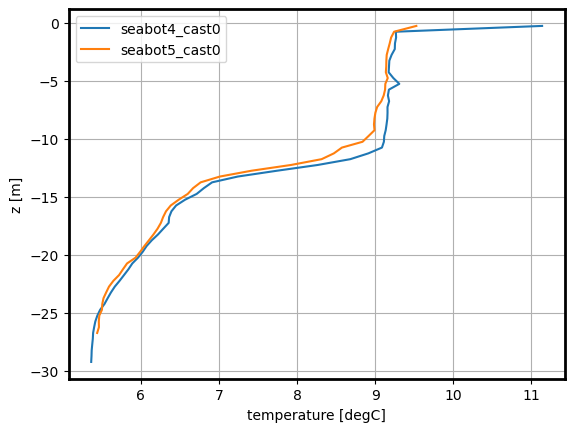

In [28]:
fig, ax = plt.subplots(1,1)
for c, df in P.items():
    ax.plot(df["temperature"], df.z, label=c)
ax.legend()
ax.grid()
ax.set_xlabel("temperature [degC]")
ax.set_ylabel("z [m]")

**Notes - Guerlédan 2023/10:**

- Profiles stop at 14.5 m depth which is not sufficient to capture the thermocline, make sure some profile are going over the full lake depth

In [29]:
if cp["name"]=="guerledan_202310":
    dTdz = 1.2 # degC/m
    ds = P["seabot3_cast0"]
elif cp["name"]=="guerledan_202402":
    dTdz = 1. # degC/m
    ds = P["seabot4_cast0"]

In [30]:
# instantiate float object
f = fl.autonomous_float(model='seabot')
f.init_piston()
f.piston.update_d(5e-2)

w = fl.waterp(**{v: ds[v].values for v in ["temperature", "salinity", "pressure"]}, lon=sb.g_lon, lat=sb.g_lat)

# check drag consistent with interns' report:
u = .3 # m/s
print(f"Drag force in Newton for u = {u:.2f} m/s: ", -f["m"]*f.get_cd(u, 0.)*u) # drag in Newtons

Piston max volume set from max displacement
Drag force in Newton for u = 0.30 m/s:  -0.6299713199999999


-270.7 g  were added to the float in order to be at equilibrium at 15 dbar 



(174.75, 174.9474408967816)

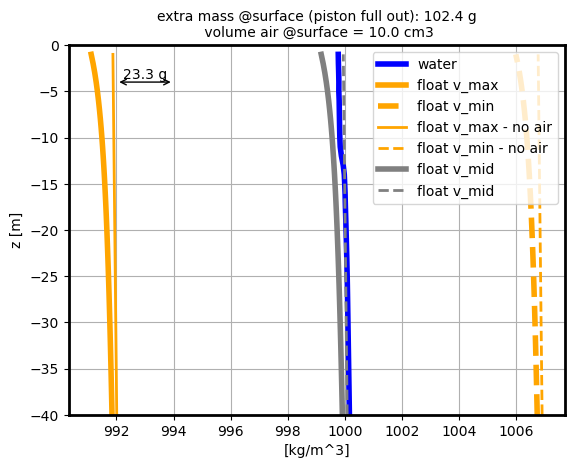

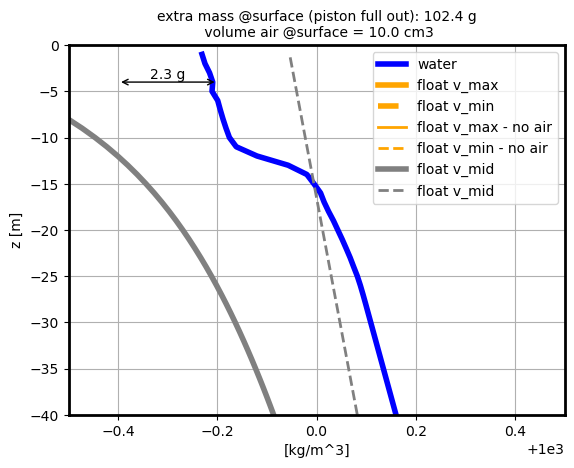

In [31]:
# adjust mass to target one depth
z_equilibrium = -15.
_w = w.at(z=z_equilibrium, extra=True)
rho_w, p, temp, N2 = _w["rho"], _w["pressure"], _w["temperature"], _w["N2"]
f.adjust_m(p,temp,rho_w, offset=0.)

# plot 
z=np.arange(-40.,0.,1.)
v_air = 10
ax = fl.plot_float_density(z, f, w, v_air=v_air*fl.cm3, mid=f.piston.vol, show_no_air=True) #, xlim=(999, 1001))
ax = fl.plot_float_density(z, f, w, v_air=v_air*fl.cm3, mid=f.piston.vol, show_no_air=True, xlim=(999.5, 1000.5))

# check full volume change available
7.5*23.3, 11e-2*f.piston.A*1000e3 # g

In [32]:
# base case: depth dependance + at a single depth
H = f.get_transfer_functions(w, 1e-3, (-4, -2), v_air=fl.cm3*0., Ap=f.piston.A)
H1 = f.get_transfer_functions(w, 1e-3, (-4, -2), v_air=fl.cm3*1., Ap=f.piston.A)
H10 = f.get_transfer_functions(w, 1e-3, (-4, -2), v_air=fl.cm3*10., Ap=f.piston.A)

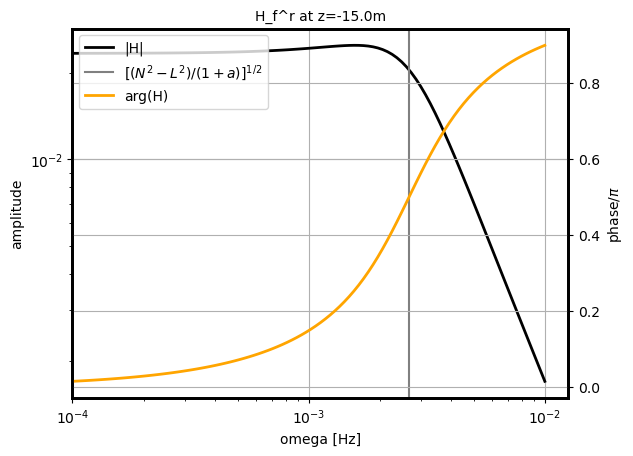

In [33]:
if cp["name"]=="guerledan_202310":
    z_eq = -14
elif cp["name"]=="guerledan_202402":
    z_eq = -13

Heq = H.sel(z=z_eq, method="nearest")

#H_label = "H_w^f"
H_label = "H_f^r"
#H_label = "H_p^rbis" # looks about the same
da = Heq[H_label]
#dab = Heq["H_w^r"]

fig, ax = plt.subplots(1,1)

h0 = ax.plot(da.omega, np.abs(da), 'k', lw=2, label="|H|")
#h0b = ax.plot(da.omega, np.abs(dab), 'b', lw=2, label="|H|")
h1 = ax.axvline(np.sqrt((Heq.N2)/(1+f.a))/2/np.pi, color="0.5", ls="-", label=r"$[(N^2-L^2)/(1+a)]^{1/2}$")
#ax.axvline(np.sqrt((Heq.N2-Heq.L2)/(1+f.a))/2/np.pi, color="0.5", ls="--")
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_title(f"{H_label} at z={z_equilibrium:.1f}m")
ax.set_xlabel("omega [Hz]")
ax.set_ylabel("amplitude")

axp = ax.twinx()
angles = np.unwrap(np.angle(da))/np.pi
h2 = axp.plot(da.omega, angles, 'orange', lw=2, label="arg(H)")
ax.grid()
axp.grid()
axp.set_ylabel(r"phase/$\pi$")

ax.set_xlim(1e-4, None)

axp.legend(handles=[h0[0], h1, h2[0]], loc=2)

Text(0.5, 1.0, 'mean(M2-N2+L2)=1.32e-05')

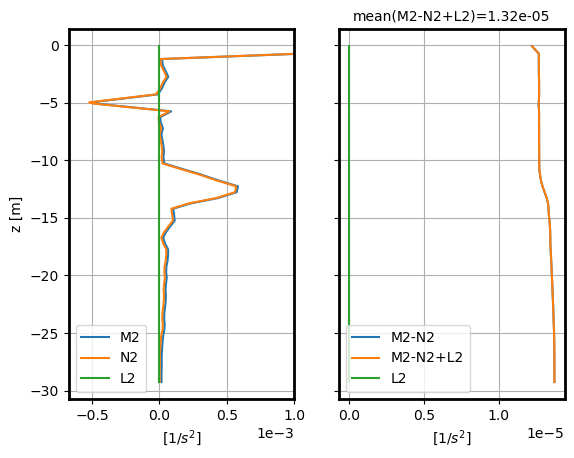

In [34]:
fig, axes = plt.subplots(1,2, sharey=True)

ax = axes[0]
ax.plot(H.M2, H.z, label="M2")
ax.plot(H.N2, H.z, label="N2")
ax.plot(H.L2, H.z, label="L2")
ax.legend()
ax.ticklabel_format(axis='x', scilimits=[-3, 3])
ax.grid()
ax.set_ylabel("z [m]")
ax.set_xlabel(r"$[1/s^2]$")
ax.set_xlim(None,1e-3)

ax = axes[1]
ax.plot(H.M2-H.N2, H.z, label="M2-N2")
ax.plot(H.M2-H.N2+H.L2, H.z, label="M2-N2+L2")
ax.plot(H.L2, H.z, label="L2")
#ax.plot(f, H.z, label="L2")
ax.legend(loc=3)
ax.grid()
ax.set_xlabel(r"$[1/s^2]$")
_mean = (H.M2-H.N2+H.L2).mean()
ax.set_title(f"mean(M2-N2+L2)={_mean:.2e}")

(-0.0010534817724861332, 0.001)

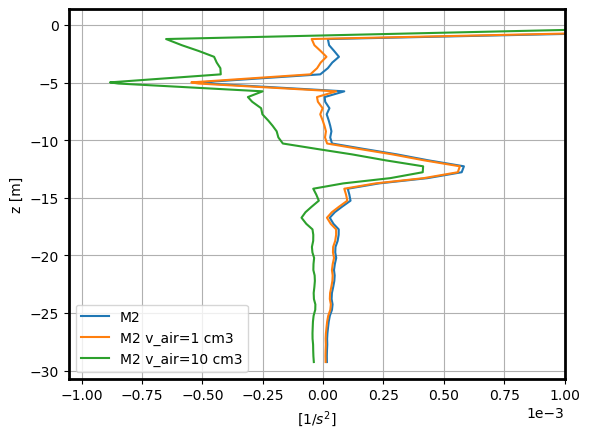

In [35]:
fig, axes = plt.subplots(1,1, sharey=True)

ax = axes
ax.plot(H.M2, H.z, label="M2")
ax.plot(H1.M2, H.z, label="M2 v_air=1 cm3")
ax.plot(H10.M2, H.z, label="M2 v_air=10 cm3")
ax.legend()
ax.ticklabel_format(axis='x', scilimits=[-3, 3])
ax.grid()
ax.set_ylabel("z [m]")
ax.set_xlabel(r"$[1/s^2]$")
ax.set_xlim(None,1e-3)

The natural stability of the float is governed by the sign of $M^2$ which depends on the amount of trapped air.

---

## isotherm following missions

In [36]:
iso_T = []
scan_T = []
for plabel, p in cp.platforms.items():
    for d in p["deployments"]:
        if "isoT" in d:
            #print(plabel,d)
            iso_T.append(M[(plabel, d)])
        if "scan" in d:
            scan_T.append(M[(plabel, d)])

In [37]:
# buid dataset with isothermal displacement

Diso = {}
for d in iso_T:
    
    df = Dcore[d]
    
    #df["depth_anomaly"] = df["depth"] - df["depth"].mean()
    df["depth_anomaly"] = df["depth_filtered"] - df["depth_filtered"].mean()   # -z_f
    dt = (df.reset_index()["time"].diff().bfill() / pd.Timedelta("1s")).values
    df["velocity_float"] = df["depth_anomaly"].diff().bfill().values / dt   # -dz_f/dt, should be close to "velocity"
    
    if "te_temperature" in df:
        df["temperature_anomaly"] = df["te_temperature"] - df["te_temperature"].mean()

        df["relative_displacement"] = df["temperature_anomaly"]/dTdz  # -(z_w-z_f)
        df["isotherm_displacement"] = df["relative_displacement"] + df["depth_anomaly"]    # -z_w
        # positive downwards
        # compensates for the float vertical displacement

        #df["temperature_rate_of_change"] =  (df["temperature"].diff()).bfill()

        # compute estimated
        #df["velocity_water"] = -df["temperature_rate_of_change"]/dTdz - df["velocity"]    
        df["velocity_water"] = df["isotherm_displacement"].diff().bfill().values / dt      # -dz_w/dt
        df["velocity_relative"] = df["relative_displacement"].diff().bfill().values / dt   # -dz_r/dt
        
    df["pi_course_anomaly"] = df["pi_course"] - df["pi_course"].mean()
    
    Diso[d] = df

### global metrics of regulation

In [38]:
def plot_hist(D, v, bins, unit):

    
    #fig, axes = plt.subplots(3, 3, figsize=(7,4), sharex=True, sharey=True)
    nx, ny = 3, 1

    i = 0
    for d in list(D):

        if i>=nx*ny:
            i=0
        if i==0:
            fig = plt.figure(figsize=(18,2))
        ax = fig.add_subplot(ny, nx, i+1)
                
        df = D[d]
        #ax = axes.T.flatten()[i]
        if v in df:
            df[v].plot.hist(
                ax=ax, bins=bins, density=True, 
                color=colors[d], 
                #label=" - ".join(d), #+df.index[0].strftime("%Y/%m/%d %H:%M")
            )
            std = df[v].std()
            ax.text(0.1, 0.9, f"std = {std:.2e} {unit}", size=8, transform=ax.transAxes)
        ax.grid()
        ax.set_title(sb.key2title(d, " "))
        if i%2==1:
            ax.set_xlabel(f"[{unit}]")
        i+=1
            
    # summary bar plot
    fig, ax = plt.subplots(1,1)
    _h = []
    _x = []
    _labels = []
    _colors = []
    i = 0
    c_past = None
    x_past = -1
    txt_off = None
    for d in list(D):
        df = D[d]
        if v in df:
            c_now = colors[d]
            if c_past is None or c_past==c_now:
                dx = 1
            else:
                dx = 2
            _x.append(x_past+dx)
            _labels.append(iM[d][1])
            _h.append(df[v].std())
            x_past = _x[-1]
            c_past = c_now
            _colors.append(c_now)
            i+=1
    p = ax.bar(_x, _h, color=_colors)
    ylims = ax.get_ylim()
    for d, x in zip(list(D), _x):
        ax.text(x, ylims[1]/40, iM[d][1], rotation=90, va="bottom", ha="center")    
    ax.grid()
    ax.set_ylabel(unit)
    ax.set_title(v)
    #ax.bar_label(p, label_type='center')
    #ax.set_xticks(_x)
    #ax.set_xticklabels(_labels)
    #plt.xticks(rotation=30)
    ax.set_xticks([])

#### temperature fluctuations = isotherm regulation performance

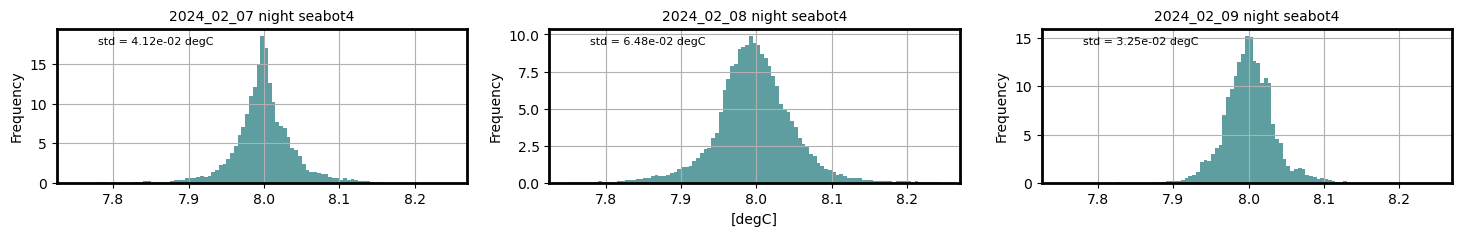

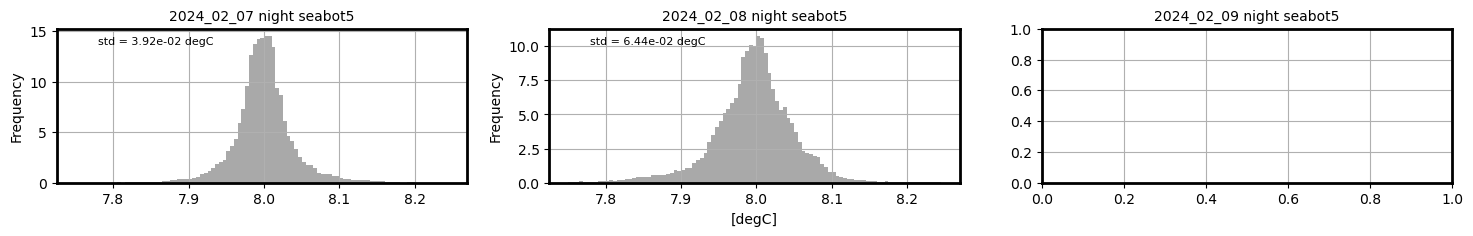

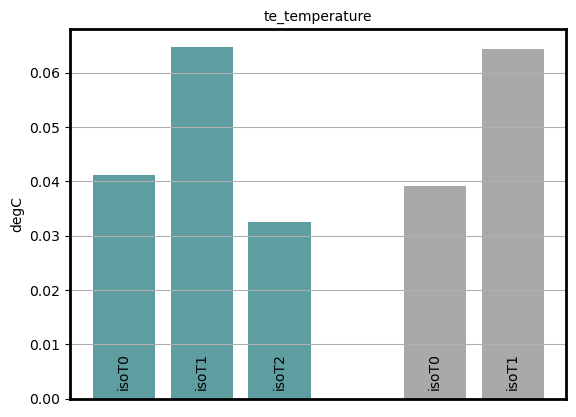

In [39]:
if cp["name"]=="guerledan_202310":
    bins = np.arange(13.8, 14.2, .005) # 2023/10
elif cp["name"]=="guerledan_202402":
    bins = np.arange(7.75, 8.25, .005) # 2024/02

plot_hist(Diso, "te_temperature", bins, "degC")        

**Notes - Guerlédan 2023/10:**

- std of about 0.02-0.04 degC ... not bad ! 😁 We must be close to instrument relative accuracy
- Question is what controls these fluctuations (intrumental noise vs high frequency fluctuations)
- 0.05 degC in a 1 degC/m thermal gradient is equivalent to a 5 cm vertical displacement

**Notes - Guerlédan 2024/02:**

- ...

#### vertical displacements = water variability (if isotherm regulation performant)

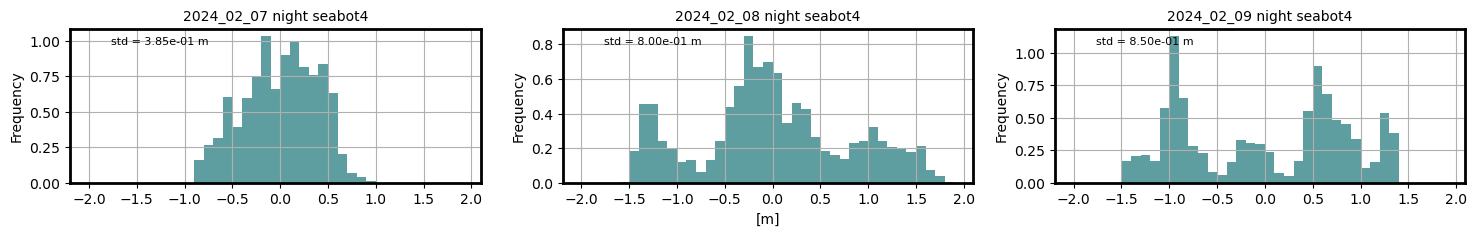

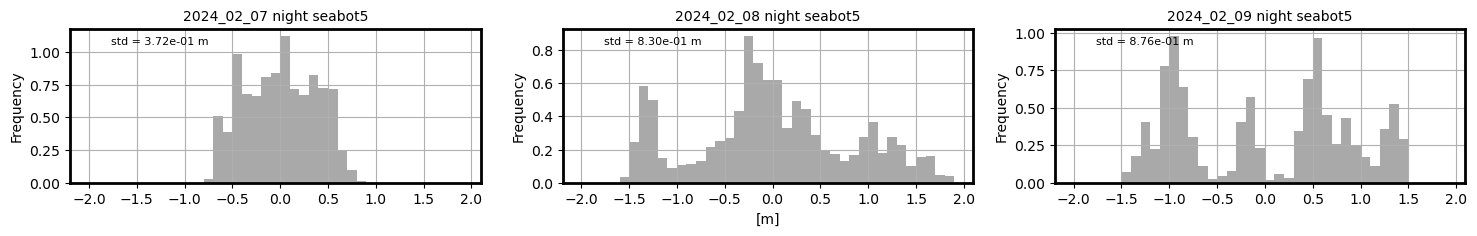

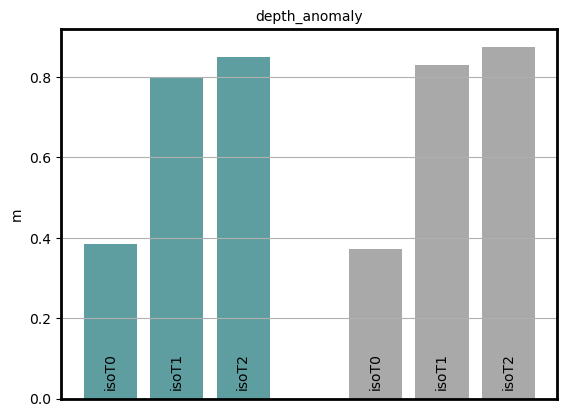

In [40]:
if cp["name"]=="guerledan_202310":
    bins = np.arange(-1., 1., .05) # 2023/10
elif cp["name"]=="guerledan_202402":
    bins = np.arange(-2., 2., .1) # 2024/02

plot_hist(Diso, "depth_anomaly", bins, "m") # - z_f

**Notes - Guerlédan 2023/10:**

- les déplacements les plus larges ont été observées sur le dernier déploiement (de l'ordre de 0.5, `2023_10_13 seabot1`)

**Notes - Guerlédan 2024/02:**

- vertical displacements are meters like

#### displacement relative to water

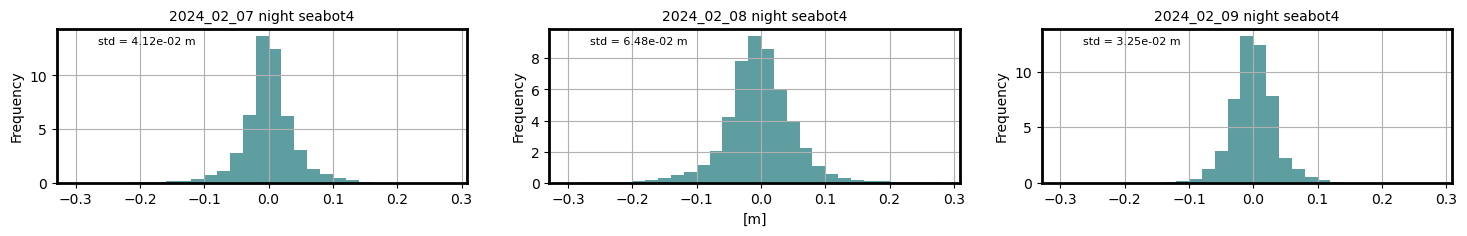

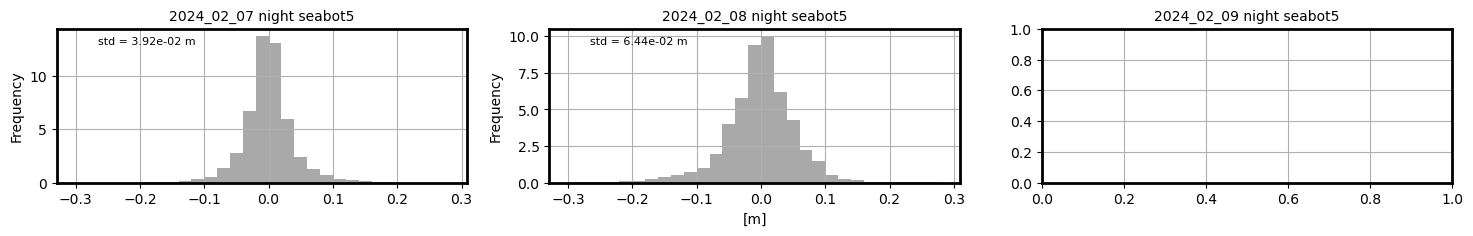

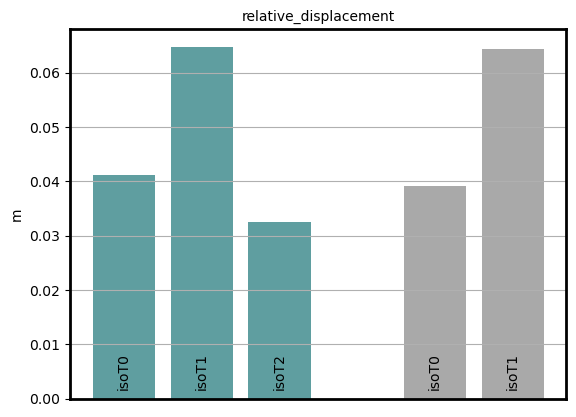

In [41]:
if cp["name"]=="guerledan_202310":
    bins = np.arange(-.1, .1, .01)
elif cp["name"]=="guerledan_202402":
    bins = np.arange(-.3, .3, .02) # 2024/02

plot_hist(Diso, "relative_displacement", bins, "m") # -(z_w-z_f)

**Notes - Guerlédan 2023/10:**

- <2 cm relative displacement is less that the vertical displacement (see preceding diagnostics) which confirms that depth variations do indeed reflect isotherm displacements

**Notes - Guerlédan 2024/02:**

- displacements relative to isotherms are about 5 cm (as expected), which is smaller than the float displacement and indicates the float successfully follows isotherms

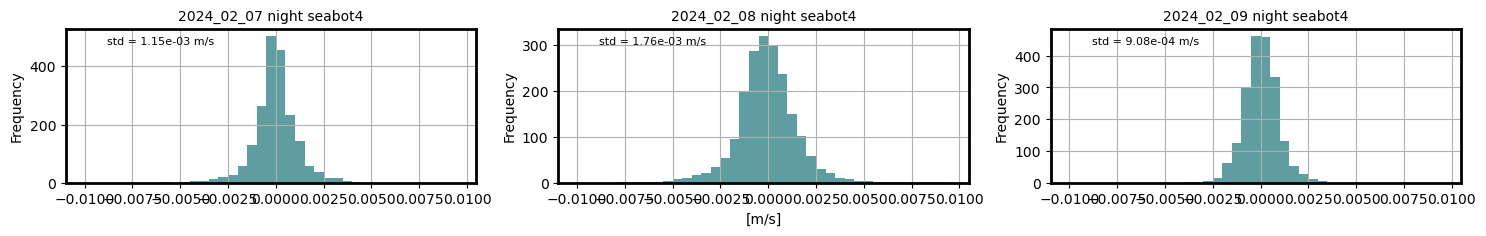

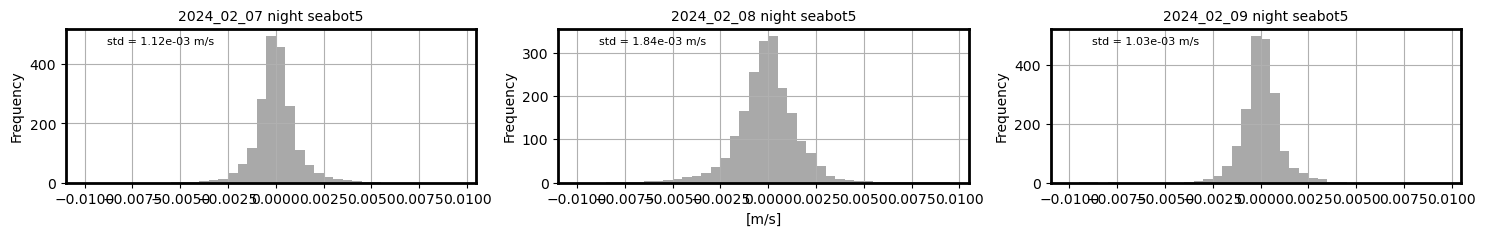

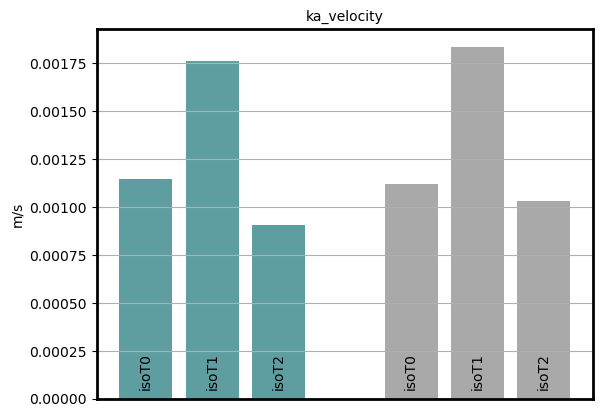

In [42]:
if cp["name"]=="guerledan_202310":
    bins = np.arange(-.005, .005, .0002)
elif cp["name"]=="guerledan_202402":
    bins = np.arange(-.01, .01, .0005)

plot_hist(Diso, "ka_velocity", bins, "m/s")
# plot_hist(Diso, "velocity_float", bins, "m/s") # very similar, as expected

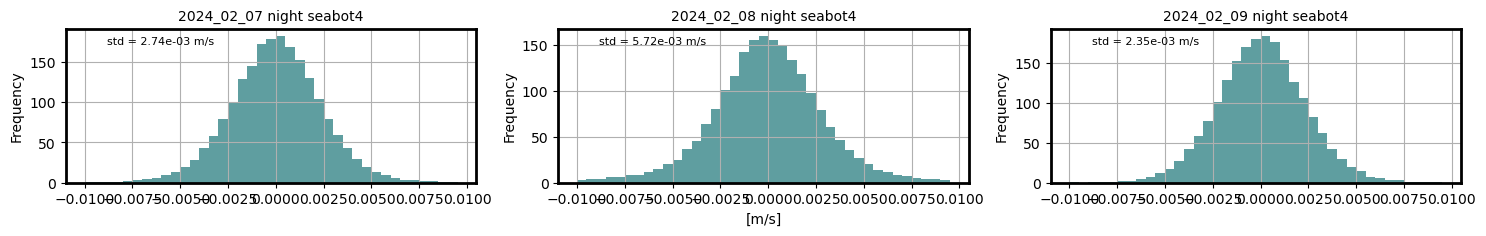

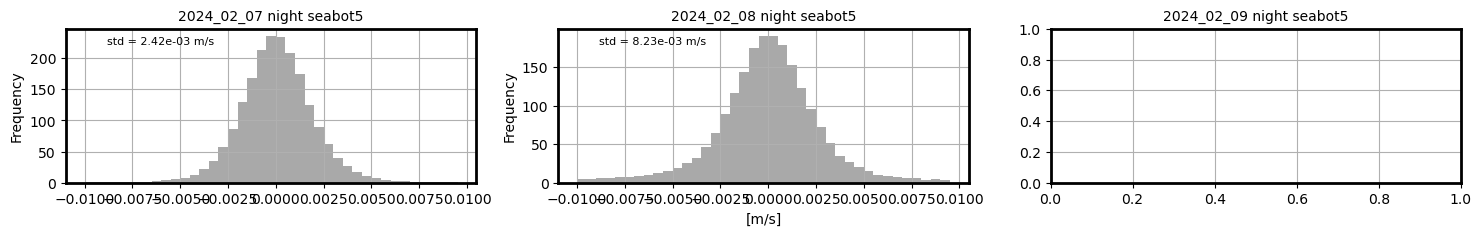

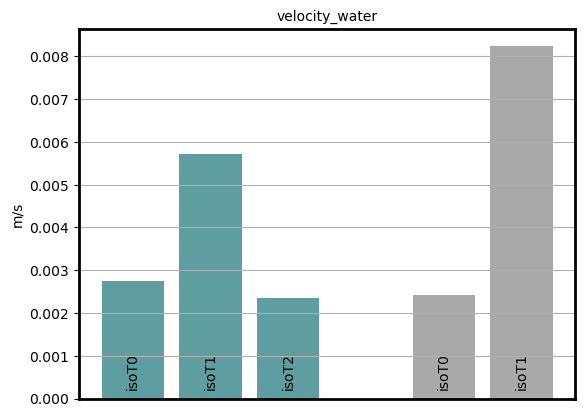

In [43]:
plot_hist(Diso, "velocity_water", bins, "m/s")

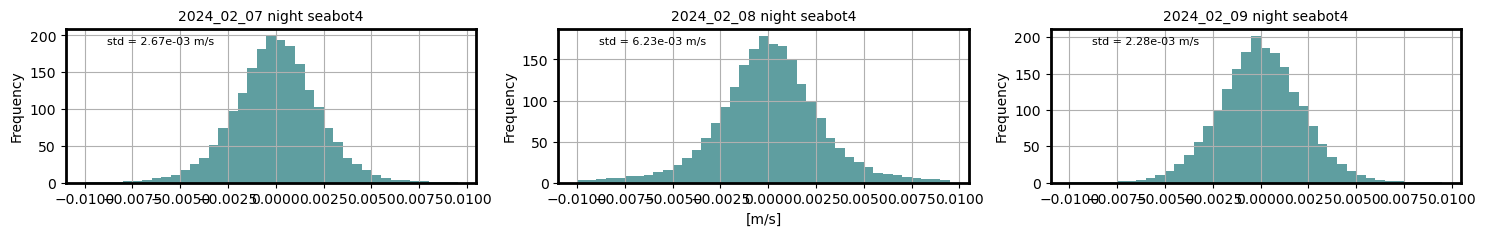

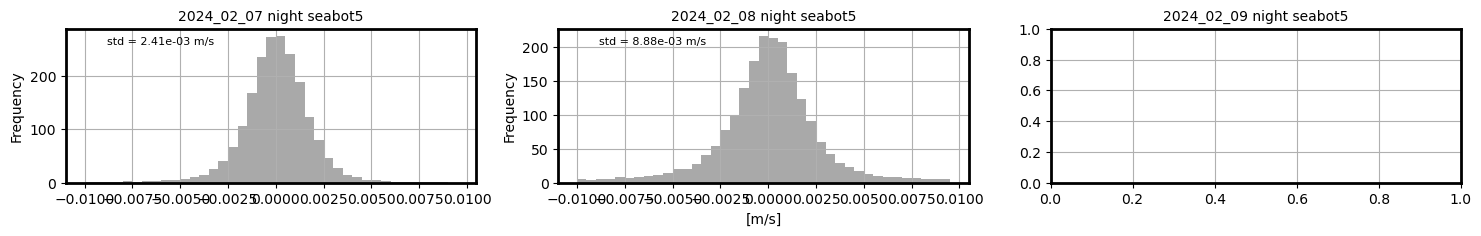

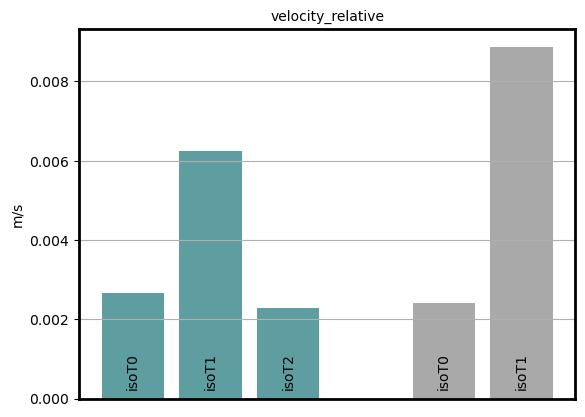

In [44]:
plot_hist(Diso, "velocity_relative", bins, "m/s")

**Notes - Guerlédan 2023/10:**

- float velocity < 1 mm/s, relative and water velocities are larger with 1-3 mm/s

**Notes - Guerlédan 2024/02:**

- Velocities diagnostics emphasize higher frequencies where the float does not follow isotherms.
- Float velocity is about 1mm/s and up to 9 times smaller than water velocity estimates and relative velocities. This means the float moves little but observe temperature fluctuations corresponding to larger displacements of the water column.

### time series

In [45]:
def compute_spectrum(df):

    # for latter comparison
    df["depth_difference"] = df["ka_depth"] - df["de_depth"]

    # show mean depth, temperature for this deployment
    print(df["ka_depth"].mean())
    if "te_temperature" in df:
        print(df["te_temperature"].mean())
    
    # tmp before bug fix
    df = df.resample("1s").interpolate()
    
    V =  ['ka_depth', 'ka_velocity',
             'depth_anomaly', 'temperature_anomaly',
             'relative_displacement', 'isotherm_displacement',
             'velocity_water', 'velocity_relative',
             'pi_course',
             'depth_difference', 'de_depth',
            ]
    V = [v for v in V if v in df]
    E = (
        df[V]
        .ts.spectrum(unit="1s", nperseg="2H")
        .to_xarray()
    )
    E = E.where(E.frequency>0, drop=True)
    E.frequency.attrs.update(units="Hz")
    
    E["acceleration"] = E["ka_depth"] * (2*np.pi*E.frequency)**2
    
    return E

In [46]:
k = iso_T[1]
df = Diso[k]
df

,ka_velocity,ka_depth,ka_offset,ka_chi,ka_chi2,ka_cz,ka_volume_air,ka_offset_total,ka_variance0,ka_variance1,...,pi_course,pi_volume,depth_anomaly,velocity_float,temperature_anomaly,relative_displacement,isotherm_displacement,velocity_water,velocity_relative,pi_course_anomaly
time,,,,,,,,,,,,,,,,,,,,,
2024-02-07 15:54:00,-0.006622,15.174369,0.000089,1.371133e-12,-1.859924e-10,1.644294,0.018379,0.000110,5.899493e-09,2.026939e-07,...,-0.068951,-0.000110,2.028611,-0.006026,-0.192438,-0.192438,1.836173,-0.012261,-0.006234,-0.004931
2024-02-07 15:54:01,-0.006723,15.166556,0.000089,1.297196e-12,-1.891189e-10,1.641385,0.018371,0.000110,5.880793e-09,2.024697e-07,...,-0.069005,-0.000110,2.022585,-0.006026,-0.198672,-0.198672,1.823912,-0.012261,-0.006234,-0.004985
2024-02-07 15:54:02,-0.006723,15.159307,0.000089,1.266741e-12,-1.904129e-10,1.640020,0.018369,0.000110,5.865598e-09,2.022183e-07,...,-0.069029,-0.000110,2.017045,-0.005539,-0.210152,-0.210152,1.806893,-0.017019,-0.011480,-0.005009
2024-02-07 15:54:03,-0.006617,15.152874,0.000089,1.279157e-12,-1.898803e-10,1.640697,0.018370,0.000110,5.854400e-09,2.019670e-07,...,-0.069032,-0.000110,2.011871,-0.005174,-0.214707,-0.214707,1.797164,-0.009729,-0.004555,-0.005011
2024-02-07 15:54:04,-0.006444,15.147079,0.000089,1.314666e-12,-1.883450e-10,1.642890,0.018372,0.000110,5.847145e-09,2.017380e-07,...,-0.069032,-0.000110,2.006971,-0.004900,-0.222437,-0.222437,1.784534,-0.012630,-0.007730,-0.005011
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-02-08 08:29:56,-0.004769,12.032779,0.000123,-8.991210e-11,-3.589280e-09,8.295614,-0.017341,0.000101,5.925208e-09,2.036589e-07,...,-0.060368,-0.000096,-1.122781,-0.001497,0.033430,0.033430,-1.089351,-0.001658,-0.000161,0.003653
2024-02-08 08:29:57,-0.007178,12.026569,0.000123,-8.991263e-11,-3.589291e-09,8.294882,-0.017340,0.000101,5.729964e-09,2.028439e-07,...,-0.059707,-0.000095,-1.125263,-0.002482,0.038834,0.038834,-1.086430,0.002921,0.005404,0.004314
2024-02-08 08:29:58,-0.009970,12.017511,0.000123,-8.991382e-11,-3.589316e-09,8.290397,-0.017338,0.000101,5.507171e-09,2.012920e-07,...,-0.059045,-0.000094,-1.129844,-0.004581,0.040857,0.040857,-1.088987,-0.002557,0.002024,0.004976


In [47]:
Ed = {k: compute_spectrum(Diso[k]) for k in iso_T}

13.946335080435052
7.999033695447058
13.157876321391988
7.999430632348285
13.87051118931167
8.000602032287006
13.95416313484656
7.999783603109935
13.137938393960141
7.997419471424433
13.9069916536896


In [48]:
#key = iso_T[6] # 2023/10
key = iso_T[1] # 2024/02

E = Ed[key]
df = Diso[key]

In [49]:
# not that this works at low-frequencies (compare to M, i.e. 2e-3 Hz - 500s = 8 min )
course2displacement = -9.81*f.piston.A/f["V"]/float(Heq.M2)

p=None
if show_hv:
    p = (
        (df["pi_course_anomaly"]*course2displacement).rename("piston induced displacement").hvplot(grid=True)
        +
        (
            df["depth_anomaly"].hvplot(grid=True) 
            * df["isotherm_displacement"].hvplot() 
            * (df["relative_displacement"]).hvplot()
            #* (df["pi_course_anomaly"]*course2displacement).rename("piston induced displacement").hvplot()
        )
        +
        (
            df["ka_velocity"].hvplot(grid=True)
            * df["velocity_water"].hvplot()
            * df["velocity_relative"].hvplot()
        )
    ).cols(1)
p

**Notes - Guerlédan 2024/02:**

The float is able to follow low-frequency (> minutes) fluctuations but not higher frequency temperature fluctuations.
This limit may be related to the float natural dynamics and/or regulation response parameters (relaxation feedback constants).

Note that for 5 minutes (0.003 Hz) fluctuations of isotherms, there is a lag of about 50 seconds with the float response but piston displacements do seem heratic (**show Thomas**).

Because of the temperature sensor, we can in theory compensate for this inability to follow isotherm.
This should thus be non-blocking for oceanographic applications.
This is provided internal waves are not "breathing" (dilating stratification).

The vertical velocity associated with high frequency isothermal displacement is about 50 cm / 3 min = 3 mm/s

### compute spectra

In [50]:
# base case: depth dependance + at a single depth
He = f.get_transfer_functions(w, 1e-3, E.frequency.values, v_air=fl.cm3*1., Ap=f.piston.A)
He = He.rename(omega="frequency")
He = He.sel(z=-14, method="nearest")

In [51]:
# util

if cp["name"]=="guerledan_202310":
    alpha = 2e-4 # 1/degC
    N = np.sqrt(9.81*alpha*dTdz)
elif cp["name"]=="guerledan_202402":
    N = None


def _add_labels(ax, N=None, legend=True):
    # buoyancy frequency
    #N = np.sqrt( 9.81 * 2e-4 * dTdz )
    if N is None:
        N = np.sqrt(float(He.N2))
    print(f"Buoyancy period = {2*np.pi/N/60:.1f} min")
    ax.axvline(N/2/np.pi, color="k", ls="--")
    ax.text(N/2/np.pi, -.05, 'N', transform=ax.get_xaxis_transform(), ha='center', va='top')
    ax.axvline(1/3600, color="k", ls="--")
    ax.text(1/3600, -.05, '1h', transform=ax.get_xaxis_transform(), ha='center', va='top')

    ax.set_xscale("log")
    ax.set_yscale("log")
    ax.set_ylim(1e-11, 1e4)

    ax.grid()
    if legend:
        ax.legend()
    ax.set_title("")

Buoyancy period = 11.1 min


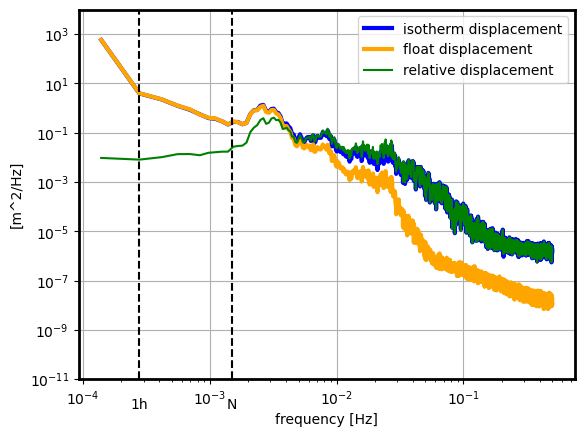

In [52]:
fig, ax = plt.subplots(1,1) #, figsize=(5,7))

E["isotherm_displacement"].plot(ax=ax, c="b", lw=3, label="isotherm displacement")
E["depth_anomaly"].plot(ax=ax, lw=3, c="orange", label="float displacement")
E["relative_displacement"].plot(ax=ax, c="g", label="relative displacement")

_add_labels(ax, N=N)
ax.set_ylabel("[m^2/Hz]");

- at low frequency, float displacements match that of isotherms and relative displacements are weak.
- at high frequencies, the float follows less isotherms. This is not expected from theory. Two potential reasons: effect of regulation or failure of theory (e.g. waves spatially smaller than the float)

Buoyancy period = 11.1 min
Buoyancy period = 11.1 min
Buoyancy period = 11.1 min
Buoyancy period = 11.1 min
Buoyancy period = 11.1 min
Buoyancy period = 11.1 min


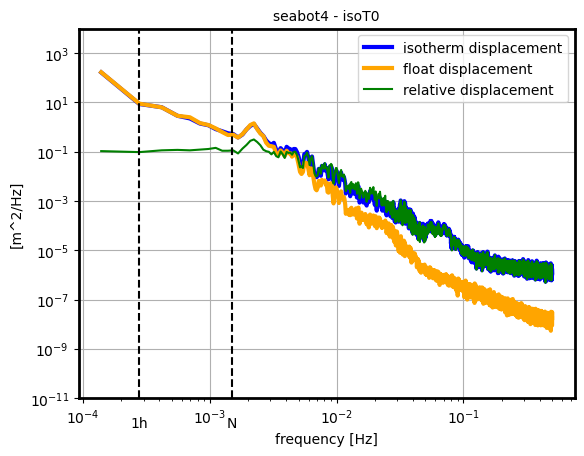

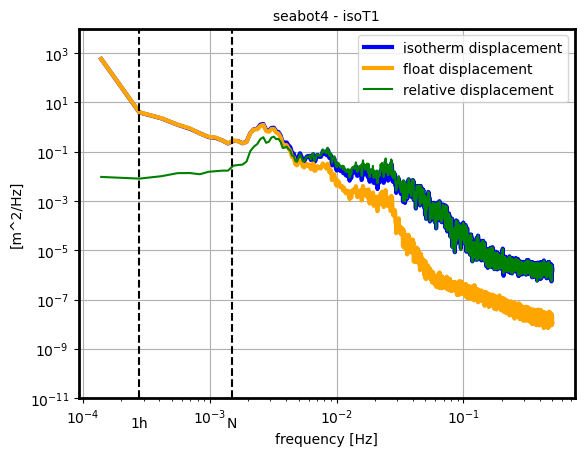

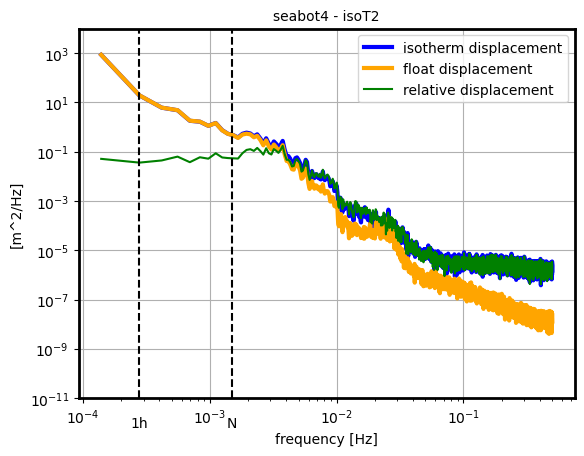

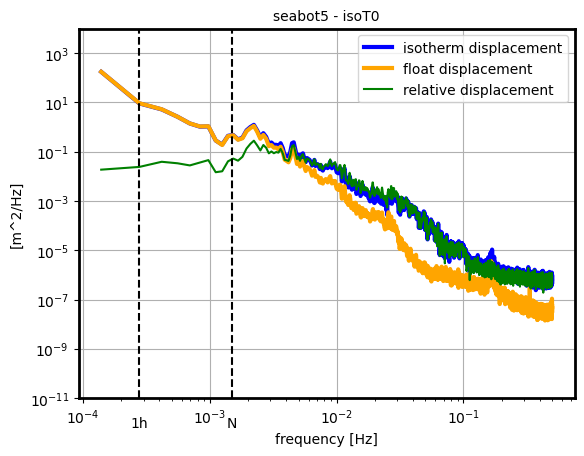

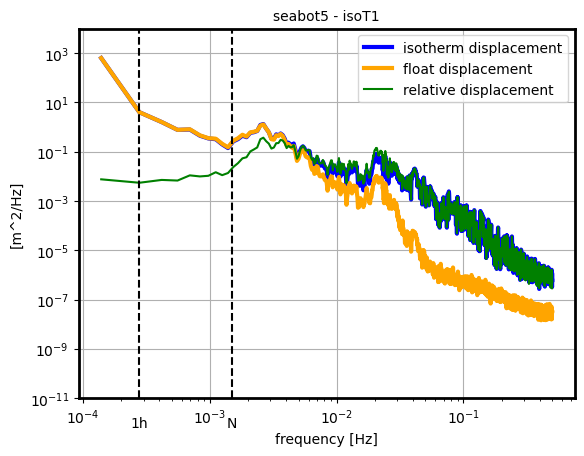

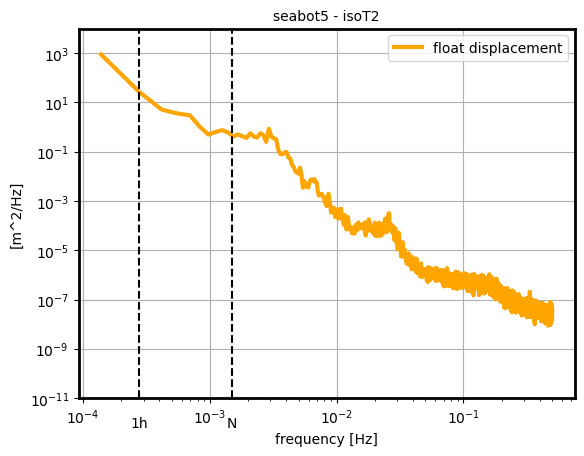

In [53]:
# for all floats

for k, _E in Ed.items():

    fig, ax = plt.subplots(1,1) #, figsize=(5,7))
    if "isotherm_displacement" in _E:
        _E["isotherm_displacement"].plot(ax=ax, c="b", lw=3, label="isotherm displacement")
    _E["depth_anomaly"].plot(ax=ax, lw=3, c="orange", label="float displacement")
    if "relative_displacement" in _E:
        _E["relative_displacement"].plot(ax=ax, c="g", label="relative displacement")

    _add_labels(ax, N=N)
    ax.set_ylabel("[m^2/Hz]");
    ax.set_title(" - ".join(iM[k]))

Buoyancy period = 11.1 min


Text(0.5, 1.0, 'acceleration')

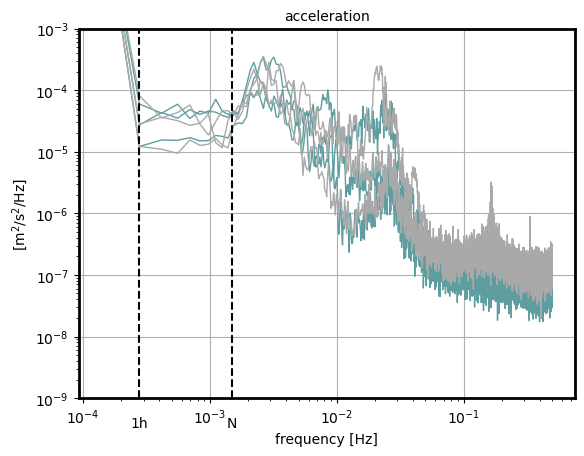

In [54]:
fig, ax = plt.subplots(1,1) #, figsize=(5,7))

for k, _E in Ed.items():
    
    #E["isotherm_displacement"].plot(ax=ax, c="b", lw=3, label="isotherm displacement")
    _E["acceleration"].plot(ax=ax, lw=1, c=cp[iM[k][0]]["color"], label="/".join(k))
    #E["relative_displacement"].plot(ax=ax, c="g", label="relative displacement")

    #E["isotherm_displacement_natural"] = E["depth_anomaly"] / np.abs(He["H_w^f"])**2
    #E["isotherm_displacement_natural"].plot(ax=ax, c="b", lw=1, ls="--", label="isotherm displacement - natural")
    #E["depth_w"] = E["isotherm_displacement"] * np.abs(He["H_w^f"])**2
    #E["depth_w"].plot(ax=ax, c="b", lw=1, ls="-", label="depth - water resp.")

    #E["depth_p"] = E["pi_course"] * np.abs(He["H_p^r"])**2
    #E["depth_p"].plot(ax=ax, c="k", lw=1, ls="-", label="depth - piston resp.")

_add_labels(ax, N=N, legend=False)
ax.set_ylabel("[m$^2$/s$^2$/Hz]");
ax.set_ylim(1e-9, 1e-3)
ax.set_title("acceleration")

Buoyancy period = 11.1 min


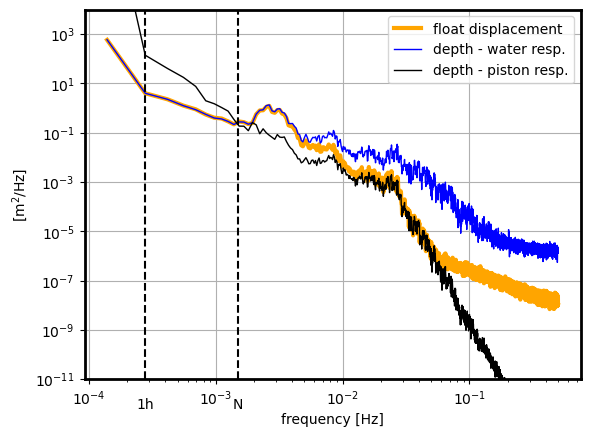

In [55]:
fig, ax = plt.subplots(1,1) #, figsize=(5,7))

#E["isotherm_displacement"].plot(ax=ax, c="b", lw=3, label="isotherm displacement")
E["depth_anomaly"].plot(ax=ax, lw=3, c="orange", label="float displacement")
#E["relative_displacement"].plot(ax=ax, c="g", label="relative displacement")

#E["isotherm_displacement_natural"] = E["depth_anomaly"] / np.abs(He["H_w^f"])**2
#E["isotherm_displacement_natural"].plot(ax=ax, c="b", lw=1, ls="--", label="isotherm displacement - natural")
E["depth_w"] = E["isotherm_displacement"] * np.abs(He["H_w^f"])**2
E["depth_w"].plot(ax=ax, c="b", lw=1, ls="-", label="depth - water resp.")

E["depth_p"] = E["pi_course"] * np.abs(He["H_p^r"])**2
E["depth_p"].plot(ax=ax, c="k", lw=1, ls="-", label="depth - piston resp.")

_add_labels(ax, N=N)
ax.set_ylabel("[m$^2$/Hz]");

- at low frequencies, water motions and piston displacements may equally explain float displacements
- around N, the float moves more than what may be attributed to piston displacements and the float is likely being moved by water motions
- at higher frequencies, the piston may be responsible for dispklacements up until frequencies of about 0.03 Hz (30s) where the effect of the piston drops sharply.

**Should we try to estimate transfer functions and compare them with theoretical ones ?**

Buoyancy period = 11.1 min


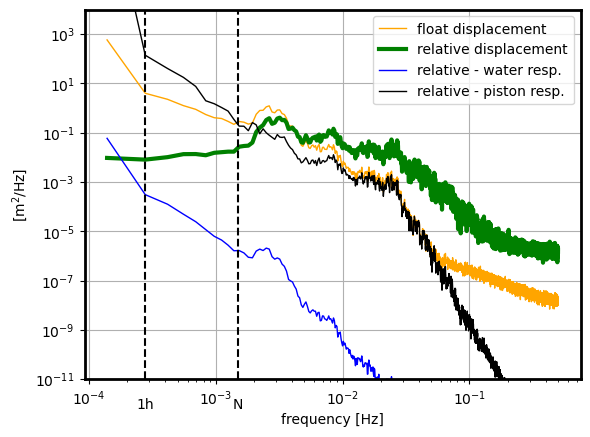

In [56]:
fig, ax = plt.subplots(1,1) #, figsize=(5,7))

E["depth_anomaly"].plot(ax=ax, lw=1, c="orange", label="float displacement")
E["relative_displacement"].plot(ax=ax, lw=3, c="g", label="relative displacement")

E["relative_w"] = E["isotherm_displacement"] * np.abs(He["H_w^r"])**2
E["relative_w"].plot(ax=ax, c="b", lw=1, ls="-", label="relative - water resp.")

E["relative_p"] = E["pi_course"] * np.abs(He["H_p^r"])**2
E["relative_p"].plot(ax=ax, c="k", lw=1, ls="-", label="relative - piston resp.")

_add_labels(ax, N=N)
ax.set_ylabel("[m$^2$/Hz]");

- relative motions have a flat spectrum up until about 0.01 Hz (100s) where it starts decaying with frequency.
- theory and inferred isotherm displacements predict relative displacements much weaker than those actually observed. This may be explained by the effect of the piston and/or and/or failure at estimating isotherm displacements and/or failure of theory. Piston displacements should induce larger relative displacements than those actually observed (??? bug in estimation of the reponse to water motions?).
- starting at N and provided estimates of the relative displacement is accurate, the piston cannot explain observed relative displacements and is therefore unlikely responsible for thoses

Buoyancy period = 11.1 min


(1e-20, 1e-05)

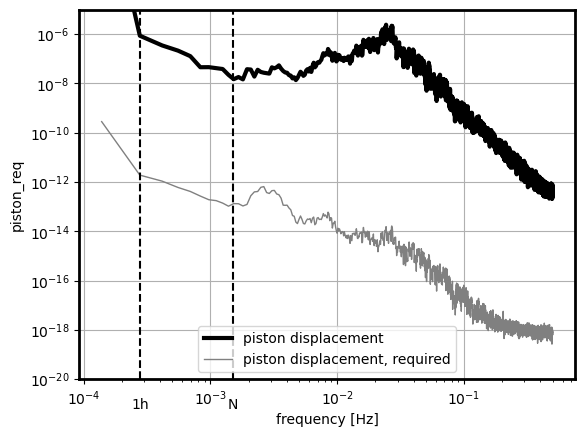

In [57]:
fig, ax = plt.subplots(1,1) #, figsize=(5,7))

E["pi_course"].plot(ax=ax, lw=3, c="k", label="piston displacement")
#E["relative_displacement"].plot(ax=ax, lw=3, c="g", label="relative displacement")

E["piston_req"] = E["isotherm_displacement"] * np.abs(He["H_w^r"]/He["H_p^r"])**2
E["piston_req"].plot(ax=ax, c="0.5", lw=1, ls="-", label="piston displacement, required")

_add_labels(ax, N=N)
#ax.set_ylabel("[m$^2$/Hz]");
ax.set_ylim(1e-20, 1e-5)

- if theory holds, the piston is moving much more than what is required to hold an isothermal behavior

Buoyancy period = 11.1 min


(1e-10, 0.1)

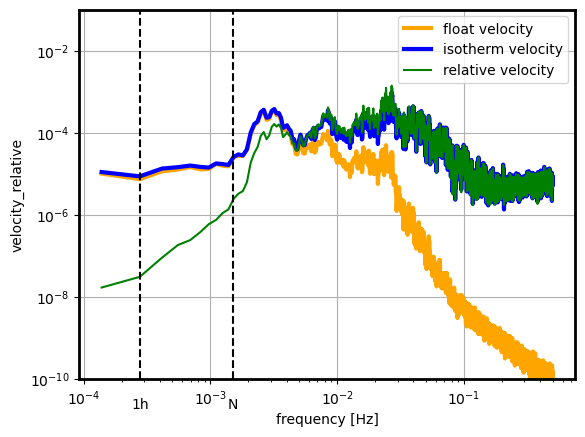

In [58]:
fig, ax = plt.subplots(1,1)

E["ka_velocity"].plot(ax=ax, color="orange", lw=3, label="float velocity")
E["velocity_water"].plot(ax=ax, color="b", lw=3, label="isotherm velocity")
E["velocity_relative"].plot(ax=ax, color="g", label="relative velocity")

_add_labels(ax, N=N)
#ax.set_ylabel("[m$^2$/Hz]");
ax.set_ylim(1e-10, 1e-1)

Kalman depth vs raw depth

Buoyancy period = 11.1 min


(1e-09, 10000.0)

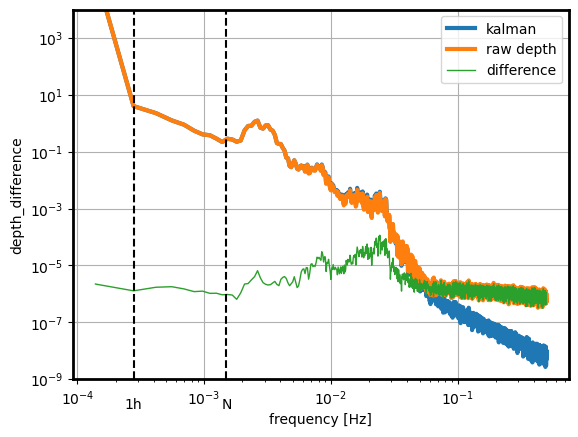

In [59]:
fig, ax = plt.subplots(1,1)

E["ka_depth"].plot(ax=ax, lw=3, label="kalman")
E["de_depth"].plot(ax=ax, lw=3, label="raw depth")
E["depth_difference"].plot(ax=ax, lw=1, label="difference")
#E["velocity_relative"].plot(ax=ax, color="g", label="relative velocity")

_add_labels(ax, N=N)
#ax.set_ylabel("[m$^2$/Hz]");
ax.set_ylim(1e-9, 1e4)

The noise floor starts at 0.05 Hz (20 seconds)

---

## dynamical equation reconstruction

- level 0: $z_f$, water motions left as residual
- level 1: $z_r$ (with uncertainty around relation motion estimations)

In [60]:
# init eos to get density
import gsw

df['depth'] = df['ka_depth']
df['velocity'] = df['ka_velocity']
df['temperature'] = df['te_temperature']
df['salinity'] = 0.
df['lon'], df['lat'] = sb.g_lon, sb.g_lat
df.sw.init()
df["rho_water"] = gsw.density.rho(df.SA, df.CT, df.pressure)

some values of longitude and latitudes are NaN, you may want to fill in with correct values


In [61]:
ds = df[["velocity", "depth", "pi_volume", "rho_water"]].to_xarray()

# estimate acceleration
ds["acceleration"] = ds["velocity"].differentiate("time", datetime_unit="1s")
ds["dyn_acceleration"] = -(1+f["a"])*ds["acceleration"]

# estimate drag
ds["c_d"] = f.get_cd(-ds["velocity"], 0.)
ds["dyn_drag"] = -ds.c_d * ds["velocity"]

# estimate buoyancy force: linearized, with piston
g = 9.81

# this what we do if we didn't know temperature and it would be wrong because 
# it would not faithfully account for density of surrounding water
#_w = w.at(z=ds["depth"])
#ds["rho_water"] = _w["rho"]
# if we use temperature instead

ds["rho_f"] = f.rho(z=-ds["depth"], waterp=w)
#rho_ref = f["m"]/f["V"]
rho_w_mean = ds["rho_water"].mean()
rho_f_mean = ds["rho_f"].mean()
ds["dyn_buoy_water"] = -g*(ds["rho_water"]-rho_w_mean)/rho_f_mean
ds["dyn_buoy_float"] =  g*(ds["rho_f"]-rho_f_mean)/rho_f_mean
ds["dyn_buoy_piston"] = -g*ds["pi_volume"]/f["V"]

# estimate residual
def add_residual(ds):
    ds["dyn_residual"] = (
        ds["dyn_acceleration"] + ds["dyn_drag"] 
        + ds["dyn_buoy_water"] + ds["dyn_buoy_float"] + ds["dyn_buoy_piston"]
    )
# enforce null average
add_residual(ds)
ds["dyn_buoy_piston"] = ds["dyn_buoy_piston"] - ds["dyn_residual"].mean()
add_residual(ds)

dyn = [
    "dyn_acceleration", "dyn_drag", 
    "dyn_buoy_water", "dyn_buoy_float", "dyn_buoy_piston",
    "dyn_residual",
]


In [62]:
p=None
if show_hv:
    _df = ds[dyn].to_dataframe()
    p = _df.drop(columns=["z", "z_bg"]).hvplot(title="dynamical reconstruction [m/s2]")
p

In [63]:
_a = 1e-3
_v = _a * f.V/g /fl.cm3 
print(f"an acceleration of {_a:.0e} m/s^2 corresponds to a volume difference of {_v:.02f} cm3")

an acceleration of 1e-03 m/s^2 corresponds to a volume difference of 1.19 cm3


Drag may be exagerated if the float follows isotherms (as it is to some extent the case for 5 min buoyancy oscillations).

---

## thermocline scanning experiment

One up/down cycle took 7 minutes ... this is dangerously close to N fluctuations

In [ ]:
def plot_scatter(df):

    fig, ax = plt.subplots(1,1, figsize=(10, 5))

    _df = df.reset_index()
    _df = _df.loc[_df.ka_velocity>0] # downward profiles

    _df.plot.scatter("time", "depth_filtered", c="te_temperature", s=5, ax=ax, cmap=cm.thermal)
    ax.grid()

    ax.invert_yaxis()

#

In [ ]:
plot_scatter(Dcore[scan_T[0]])
plot_scatter(Dcore[scan_T[1]])

In [ ]:
# with hvplot

#df = DT[9]
#df = df.reset_index()
#df = df.loc[df.velocity>0] # select downward profiles

#_df.hvplot.scatter("time", "depth", c="temperature", s=10, ax=ax, cmap=cm.thermal).opts(invert_yaxis=True)

#### depth-time bin average

In [ ]:
def depth_time_bin_average(df, dz=.1, freq="10T", ascent=False):

    df = df.reset_index()
    if ascent is None:
        pass
    elif ascent:
        df = df.loc[df.ka_velocity<0] # select downward profiles
    else:
        df = df.loc[df.ka_velocity>0] # select downward profiles
        

    dbins = np.arange(15, 20.5, dz)
    tbins = pd.date_range(df.time.iloc[0], df.time.iloc[-1], freq=freq)

    #df["depth_cut"] = pd.cut(df["depth"], dbins)
    df["depth_cut"] = pd.cut(df["depth_filtered"], dbins)
    df["time_cut"] = pd.cut(df["time"], tbins)


    dfb = df.groupby(["depth_cut", "time_cut"]).mean().reset_index()

    dfb["depth"] = dfb["depth_cut"].apply(lambda i: i.left)
    dfb["time"] = dfb["time_cut"].apply(lambda i: i.left)

    ds = dfb.set_index(["depth", "time",]).to_xarray()

    return ds


def bin_plot(df, iso=None, **kwargs):

    ds = depth_time_bin_average(df, **kwargs)

    fig, ax = plt.subplots(1,1)

    #DT[8]["depth"].plot(ax=ax, color="k")
    #DT[10]["depth"].plot(ax=ax, color="0.3")
    #DT[8]["depth_filtered"].plot(ax=ax, color="k")
    #DT[10]["depth_filtered"].plot(ax=ax, color="0.3")
    if iso is not None:
        df = Dcore[iso]
        df["depth_filtered"].plot(ax=ax, color="k")

    ds["te_temperature"].plot(ax=ax, cmap=cm.thermal)
    ds["te_temperature"].plot.contour(ax=ax, levels=[12, 13, 14, 15, 16], colors="w")

    ax.invert_yaxis()
    ax.grid()

In [ ]:
iso = M[("seabot4", "isoT2")]

bin_plot(Dcore[scan_T[0]], iso=iso, ascent=None)
bin_plot(Dcore[scan_T[0]], iso=iso, ascent=True)
#bin_plot(Dcore[scan_T[0]], ascent=False)

In [ ]:
bin_plot(Dcore[scan_T[1]], iso=iso, ascent=None)

---

## temperature delay - to be updated

#### 1. simple offset on temperature: 

Seems to work within the water column but not at deepest levels nor at the surface

In [ ]:
key = list(Dc)[1]
print(key)
df = Dc[key]

fig, ax = plt.subplots(1,1)

delays = ["0s", "-2s", "-4s"]
_colors = pin.get_cmap_colors(len(delays))

for delay, c in zip(delays, _colors):
    _df = df.copy()
    _df["temperature"] = _df["temperature"].shift(freq=delay) # avance
    #_df.plot.scatter("temperature","depth", s=1, c=c, ax=ax, label=delay)
    ax.plot(_df.temperature, _df.depth, color=c, label=delay)

ax.invert_yaxis()
ax.grid()
ax.legend()
ax.set_xlim(None,10)

#### 2. low-pass filter depth instead

seems to behave similarly, 2s seconds seems a reasonable choice

In [ ]:
df = DF[0]

fig, ax = plt.subplots(1,1)

taus = [2, 3, 4]
_colors = pin.get_cmap_colors(len(taus))

for tau, c in zip(taus, _colors):
    _df = df.copy()
    append_depth_filtered(_df, tau)
    ax.plot(_df.temperature, _df.depth_filtered, label=f"tau={tau}")

ax.invert_yaxis()
ax.grid()
ax.legend()

---
## archived material ...

In [ ]:
df = DT[9]

_df = df.reset_index()
_df["mask"] = 0.
_df["mask"].where(_df.velocity>0, other=1., inplace=True)

_df["mask_cumsum"] = _df["mask"].cumsum()

_df["mask_cumsum"].hvplot()

In [ ]:
df = DT[9]

_df = df.reset_index()

_df = _df.loc[_df.velocity>0] # downward profiles

dt = _df["time"].diff()/pd.Timedelta("1T")
print("Time intervals in minutes:")
print(np.unique(dt))

#(_df["time"].diff()/pd.Timedelta("1s")).plot.hist(bins=np.arange(0,10,1), log=True) #.plot()

In [ ]:
_df = df.reset_index()

_df = _df.loc[_df.velocity>0] # downward profiles
_dt = _df["time"].diff()/pd.Timedelta("1T")
bottom = _df.loc[_dt>1]

_df = df.reset_index()
_df = _df.loc[_df.velocity<0] # downward profiles
_dt = _df["time"].diff()/pd.Timedelta("1T")
top = _df.loc[_dt>1]

In [ ]:
(df.reset_index()["depth"].hvplot()
 * bottom["depth"].hvplot() 
 * top["depth"].hvplot() 
)